# IMPORTS

In [1]:
import optuna
import pickle
import requests

import pandas            as pd
import numpy             as np
import seaborn           as sns
import scikitplot        as skplt
import matplotlib.pyplot as plt

from xgboost                          import XGBClassifier
from lightgbm                         import LGBMClassifier
from catboost                         import CatBoostClassifier
from sklearn.model_selection          import train_test_split, cross_val_score, StratifiedKFold
from sklearn.compose                  import ColumnTransformer
from sklearn.pipeline                 import Pipeline
from sklearn.preprocessing            import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics                  import (precision_score, recall_score, roc_auc_score, f1_score, 
                                              average_precision_score, accuracy_score, confusion_matrix)
from sklearn.ensemble                 import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors                import KNeighborsClassifier
from category_encoders.target_encoder import TargetEncoder

from IPython.display                  import display, HTML
from warnings                         import filterwarnings

## HELPER FUNCTIONS

In [202]:
# aumentando a área de exibição do notebook
display(HTML("<style>.container { width:75% !important; }</style>"))

In [3]:
# modelo de machine learning
def ml_model(model, X_train, y_train, X_test):
    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    st_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    score = cross_val_score(model, X_train, y_train, cv=st_fold, scoring='roc_auc', n_jobs=-1)
    
    return y_pred, score

In [4]:
def metrics(score, y_test, y_pred):
    # metricas observadas
    cv_score = score.mean()
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    avg_precision = average_precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    # criando um dicionario com os valores
    data = {
        'metric': ['Cross Validation Score', 'Accuracy Score', 'F1 Score', 'Precision Score',
                   'Average Precision Score', 'Recall Score', 'ROC AUC Score'],
        'value': [cv_score, accuracy, f1, precision, avg_precision, recall, roc_auc]
    }

    # gerando o dataframe
    df_metrics = pd.DataFrame(data)

    # formatando os valores das metricas
    df_metrics['value'] = df_metrics['value'].map('{:.2%}'.format)

    return df_metrics

In [5]:
# tabela com a matriz de confusão
def matrix(model, X_test, y_test):
    cm = confusion_matrix(y_test, model.predict(X_test))
    titulos = ['TN','FP','FN','TP']
    valores = [value for value in cm.flatten()]
    porcentagem = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(titulos, valores, porcentagem)]
    labels = np.asarray(labels).reshape(2,2)
    matrix_confusion = sns.heatmap(cm, annot=labels, fmt='', cmap='RdBu');
    
    return matrix_confusion

In [6]:
def curves(model, X_test, y_test):
    # curvas de acumulação e lift
    cumulative_gain_curve = skplt.metrics.plot_cumulative_gain(y_test, model.predict_proba(X_test));
    lift_curve = skplt.metrics.plot_lift_curve(y_test, model.predict_proba(X_test));
    
    return cumulative_gain_curve, lift_curve

In [7]:
# modelo e métricas
def ml_model_and_metrics(model, X_train, y_train, X_test, y_test):
    
    # modelo de machine learning
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    st_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=st_fold, scoring='roc_auc', n_jobs=-1)
    
    # metricas observadas
    cv_score = score.mean()
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    avg_precision = average_precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    # criando um dicionario com os valores
    data = {
        'metric': ['Cross Validation Score', 'Accuracy Score', 'F1 Score', 'Precision Score',
                   'Average Precision Score', 'Recall Score', 'ROC AUC Score'],
        'value': [cv_score, accuracy, f1, precision, avg_precision, recall, roc_auc]
    }

    # gerando o dataframe
    df_metrics = pd.DataFrame(data)

    # formatando os valores das metricas
    df_metrics['value'] = df_metrics['value'].map('{:.2%}'.format)
    
    # GRÁFICOS
    
    # criando os gráficos e tabelas
    fig, axs = plt.subplots(2, 2, figsize=(12,10)) # criando os subplots
    
    # GRÁFICO 1 - TABELA COM AS MÉTRICAS
    table = axs[0, 0].table(cellText=df_metrics.values, colLabels=df_metrics.columns, loc='center')
    table.auto_set_font_size(True)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)
    axs[0, 0].axis('off')
    axs[0,0].set_title('Tabela de Métricas')

    # GRÁFICO 2 - MATRIZ DE CONFUSÃO
    cm = confusion_matrix(y_test, model.predict(X_test))

    titulos = ['TN', 'FP', 'FN', 'TP']
    valores = [value for value in cm.flatten()]
    porcentagem = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(titulos, valores, porcentagem)]
    labels = np.asarray(labels).reshape(2, 2)
    axs[0,1] = sns.heatmap(cm, annot=labels, fmt='', cmap='RdBu', ax=axs[0, 1])
    axs[0,1].set_title('Matriz de Confusão')

    # GRÁFICO 3 - CURVA DE ACÚMULO

    skplt.metrics.plot_cumulative_gain(y_test, model.predict_proba(X_test), ax=axs[1,0]);
    axs[1,0].set_title('Curva de Acúmulo')

    # GRÁFICO 4 - CURVA DE LIFT
    axs[1,1] = skplt.metrics.plot_lift_curve(y_test, model.predict_proba(X_test), ax=axs[1,1]);
    axs[1,1].set_title('Curva de Lift')

    # ajustando o layout das tabelas
    plt.tight_layout()

    # exibindo os gráficos
    plt.show()

## CARREGANDO O DATASET

In [8]:
df = pd.read_csv('data/churn.csv')

In [9]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [10]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## DIMENSÃO DO DATASET

In [11]:
print('Quantidade de linhas:', df.shape[0])
print('Quantidade de colunas:', df.shape[1])

Quantidade de linhas: 10000
Quantidade de colunas: 14


## RESUMO DOS DADOS

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [13]:
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

## CHECANDO DADOS NA

In [14]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## CHECANDO DADOS DUPLICADOS

In [15]:
df.duplicated().sum()

0

## VERIFICANDO MEDIDAS ESTATÍSTICAS

In [16]:
df.describe().round(2)

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.0
mean,5000.50,15690940.57,650.53,38.92,5.01,76485.89,1.53,0.71,0.52,100090.24,0.2
std,2886.90,71936.19,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.4
min,1.00,15565701.00,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.0
25%,2500.75,15628528.25,584.00,32.00,3.00,0.00,1.00,0.00,0.00,51002.11,0.0
50%,5000.50,15690738.00,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.92,0.0
75%,7500.25,15753233.75,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.0
max,10000.00,15815690.00,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.0


# EDA

## ANÁLISE UNIVARIADA

### VERIFICANDO AS DISTRIBUIÇÕES DAS VARIÁVEIS NUMÉRICAS

In [17]:
df_numerical = df.select_dtypes(include=('int64', 'float64'))

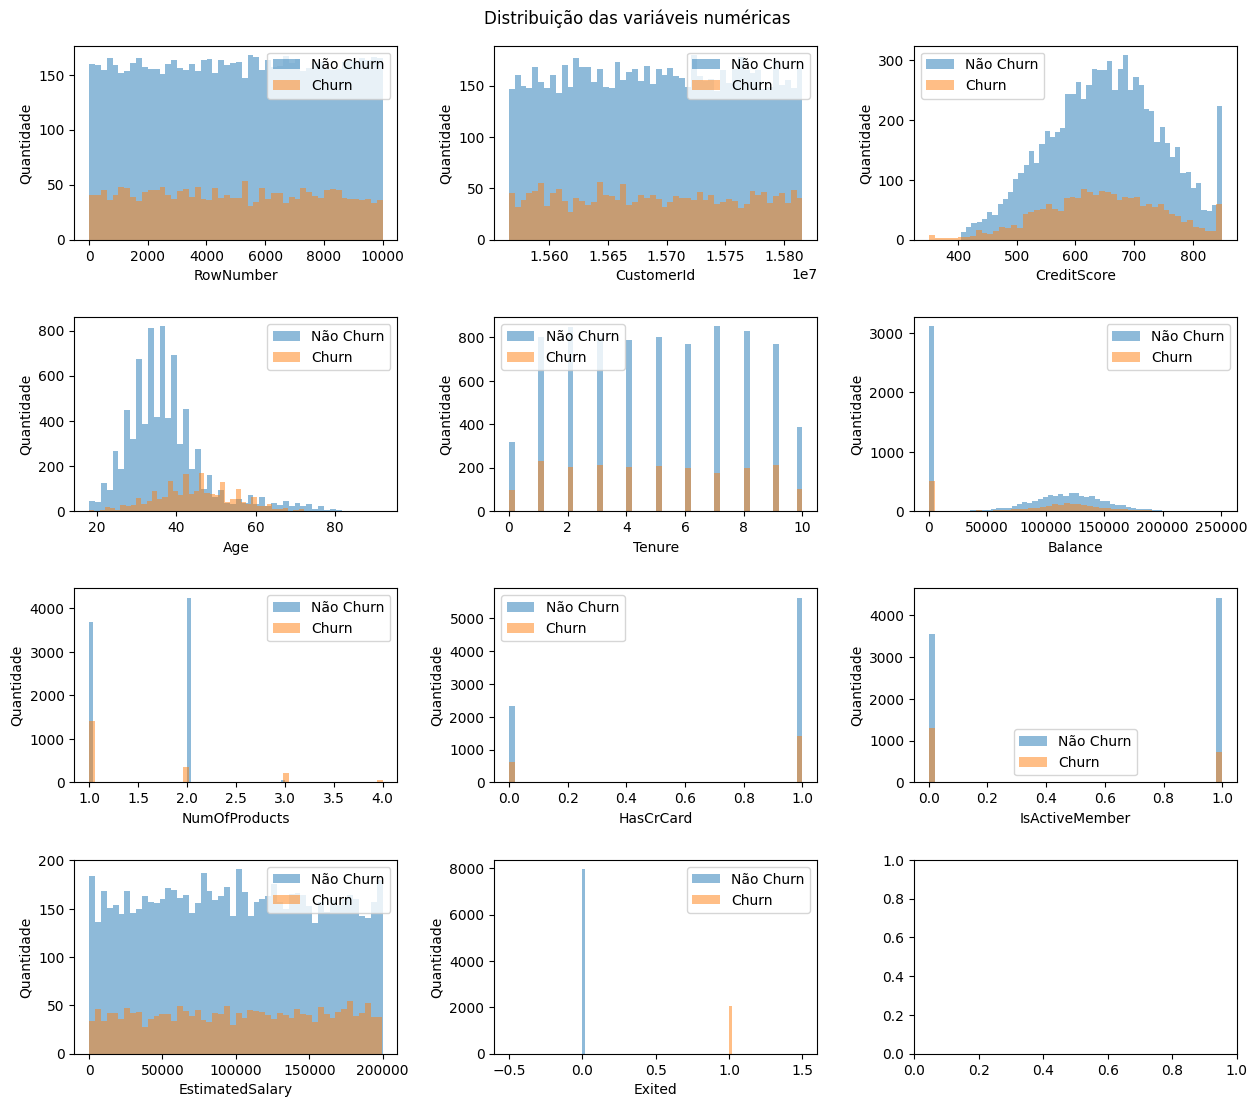

In [18]:
fig, ax = plt.subplots(4, 3, figsize=(15, 12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.95, wspace=0.3, hspace=0.4)
fig.suptitle('Distribuição das variáveis numéricas')

for i, variable in enumerate(df_numerical.columns):
    row = i // 3
    col = i % 3
    ax[row, col].hist(df_numerical.loc[df['Exited'] == 0, variable], label='Não Churn', bins=50, alpha=0.5)
    ax[row, col].hist(df_numerical.loc[df['Exited'] == 1, variable], label='Churn', bins=50, alpha=0.5)
    ax[row, col].set_xlabel(variable)
    ax[row, col].set_ylabel('Quantidade')
    ax[row, col].legend()

plt.show()

### VERIFICANDO AS DISTRIBUIÇÕES DAS VARIÁVEIS CATEGÓRICAS

In [19]:
df_categorical = df.select_dtypes(exclude=('int64', 'float64'))
df_categorical = df_categorical[['Geography', 'Gender']]

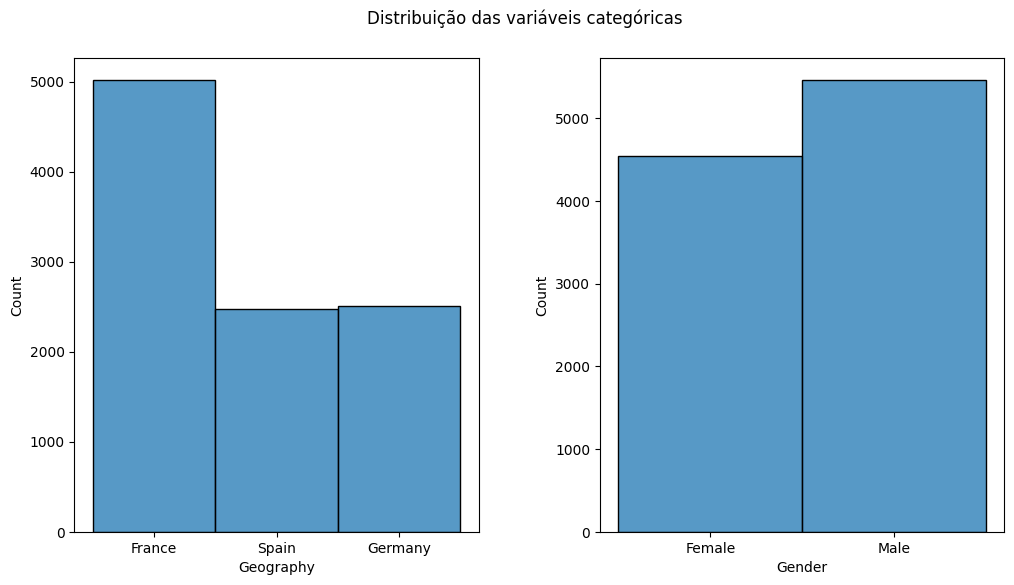

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=0.3, hspace=0.4)
fig.suptitle('Distribuição das variáveis categóricas');

for variable, subplot in zip(df_categorical.columns, ax.flatten()):
    sns.histplot(df_categorical[variable], ax=subplot)

### VERIFICANDO DISTRIBUIÇÃO DA VARIÁVEL ALVO

In [21]:
df['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

In [22]:
ratio = df['Exited'].value_counts()[0]/df['Exited'].value_counts()[1]
print(f'A proporção de clientes Não Churn para clientes Churn é de {ratio:.2f}')

A proporção de clientes Não Churn para clientes Churn é de 3.91


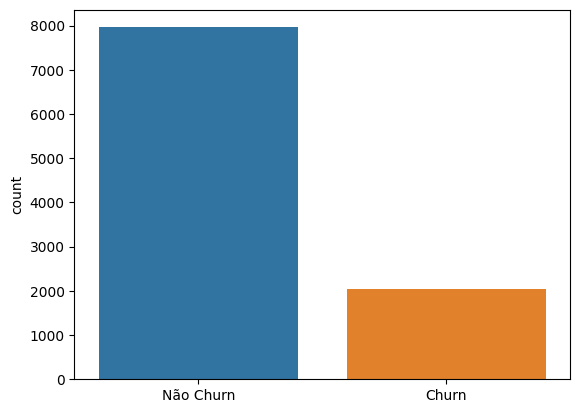

In [23]:
sns.barplot(x=['Não Churn', 'Churn'], y=df['Exited'].value_counts());

## ANÁLISE BIVARIADA

### DISTRIBUIÇÃO DE CHURN POR CREDITSCORE

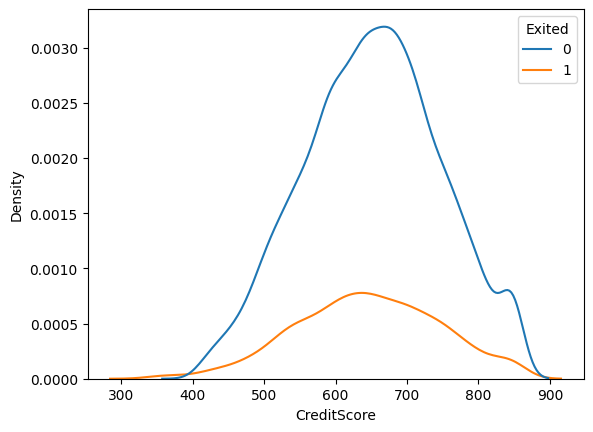

In [24]:
sns.kdeplot(data=df, x='CreditScore', hue='Exited');

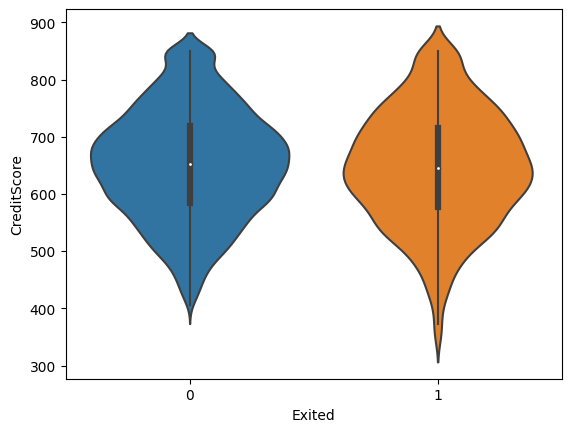

In [25]:
sns.violinplot(x=df['Exited'], y=df['CreditScore']);

### DISTRIBUIÇÃO DE CHURN POR TEMPO DE CONTA

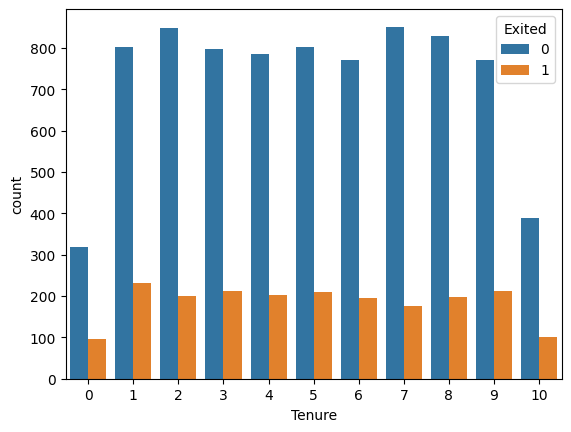

In [26]:
sns.countplot(data=df, x='Tenure', hue='Exited');

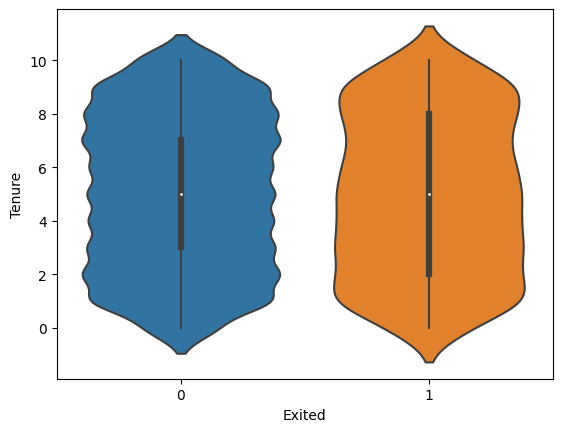

In [27]:
sns.violinplot(data=df, x='Exited', y='Tenure');

### DISTRIBUIÇÃO DE CHURN POR SALDO DE CONTA

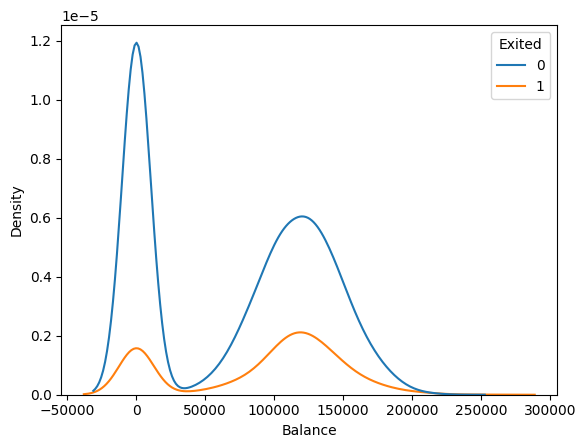

In [28]:
sns.kdeplot(data=df, x='Balance', hue='Exited');

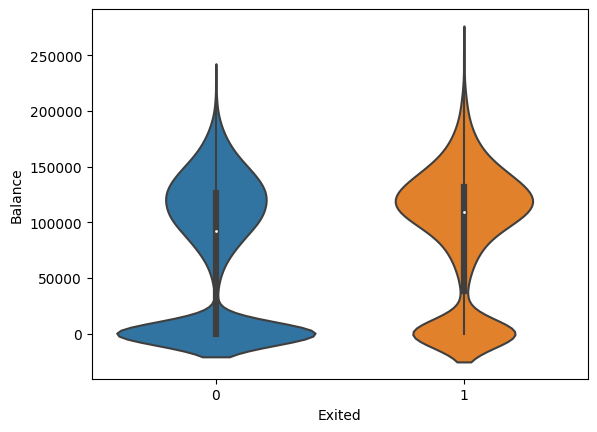

In [29]:
sns.violinplot(x=df['Exited'], y=df['Balance']);

### DISTRIBUIÇÃO DE CHURN POR IDADE

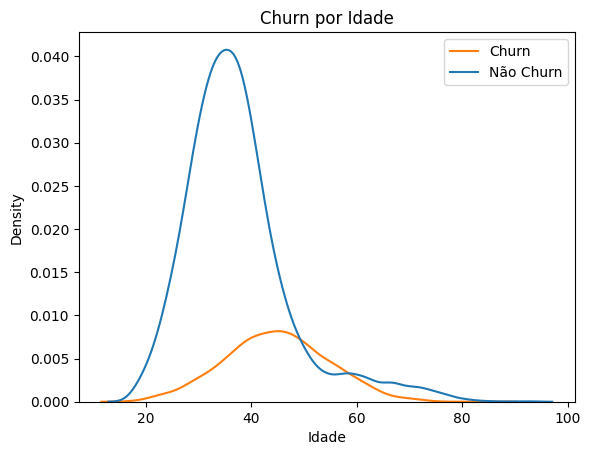

In [196]:
sns.kdeplot(data=df, x='Age', hue='Exited');
plt.title('Churn por Idade')
plt.xlabel("Idade")
plt.legend(["Churn", "Não Churn"]);

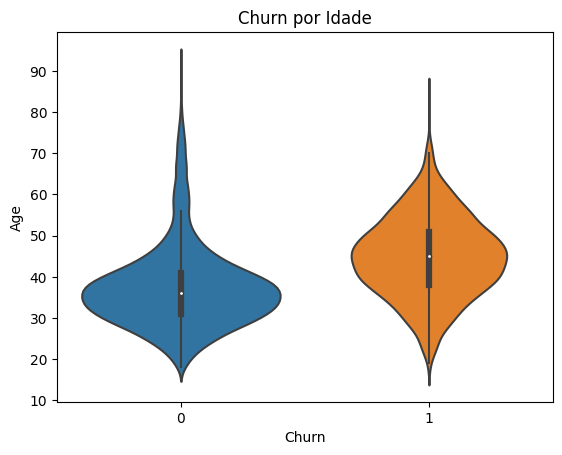

In [198]:
sns.violinplot(x=df['Exited'], y=df['Age']);
plt.title('Churn por Idade')
plt.xlabel("Churn");

### DISTRIBUIÇÃO DE CHURN POR PRODUTO

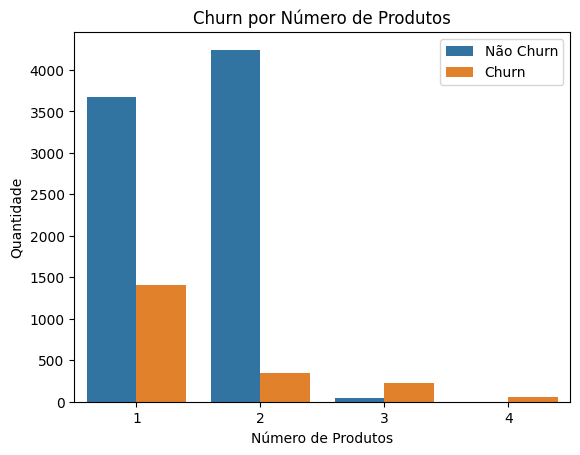

In [200]:
sns.countplot(data=df, x='NumOfProducts', hue='Exited');
plt.title('Churn por Número de Produtos')
plt.xlabel('Número de Produtos')
plt.ylabel('Quantidade')
plt.legend(['Não Churn', 'Churn']);

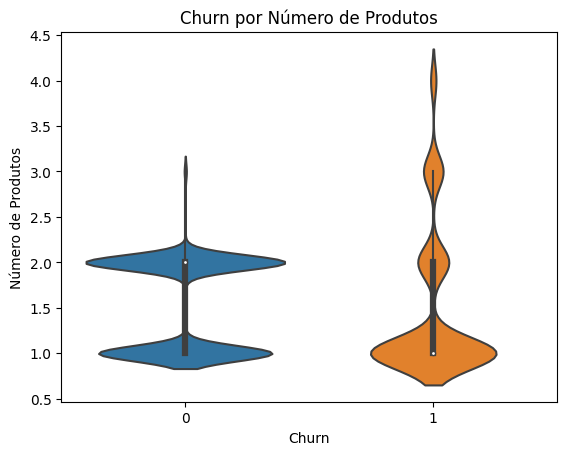

In [203]:
sns.violinplot(x=df['Exited'], y=df['NumOfProducts']);
plt.title('Churn por Número de Produtos')
plt.ylabel('Número de Produtos')
plt.xlabel("Churn");

### DISTRIBUIÇÃO DE CHURN POR POSSE DE CARTÃO DE CRÉDITO

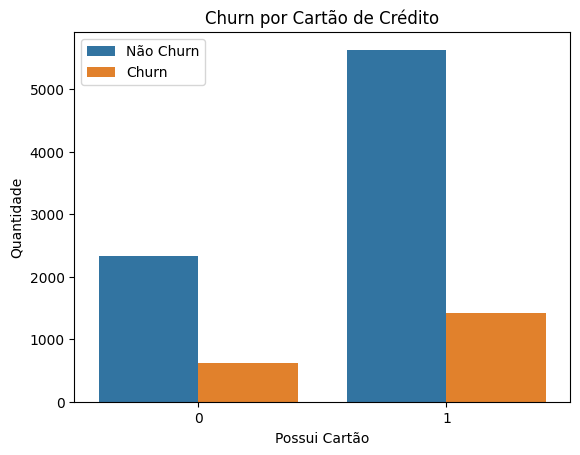

In [212]:
sns.countplot(data=df, x='HasCrCard', hue='Exited');
plt.title('Churn por Cartão de Crédito')
plt.xlabel('Possui Cartão')
plt.ylabel('Quantidade')
plt.legend(['Não Churn', 'Churn']);

### DISTRIBUIÇÃO DE CHURN POR SALÁRIO

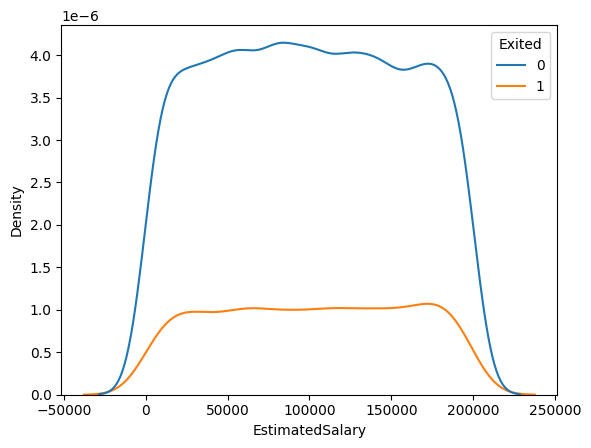

In [35]:
sns.kdeplot(data=df, x='EstimatedSalary', hue='Exited');

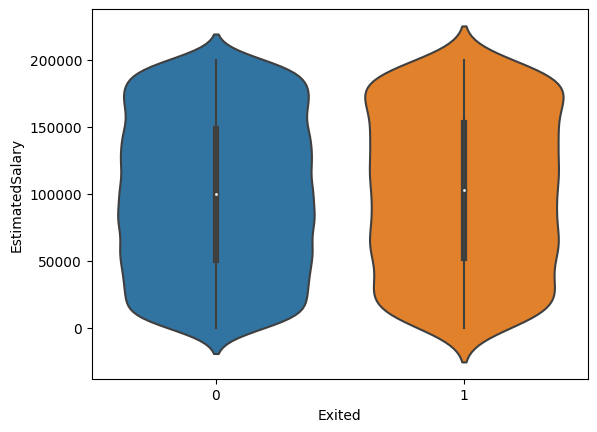

In [36]:
sns.violinplot(x=df['Exited'], y=df['EstimatedSalary']);

### DISTRIBUIÇÃO DE CHURN POR GÊNERO

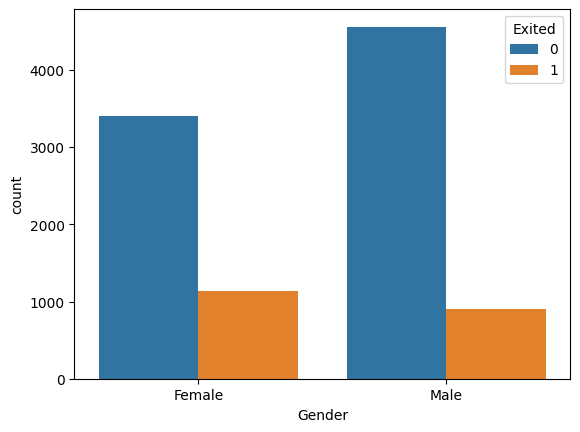

In [37]:
sns.countplot(data=df, x='Gender', hue='Exited');

### DISTRIBUIÇÃO DE CHURN POR PAÍS

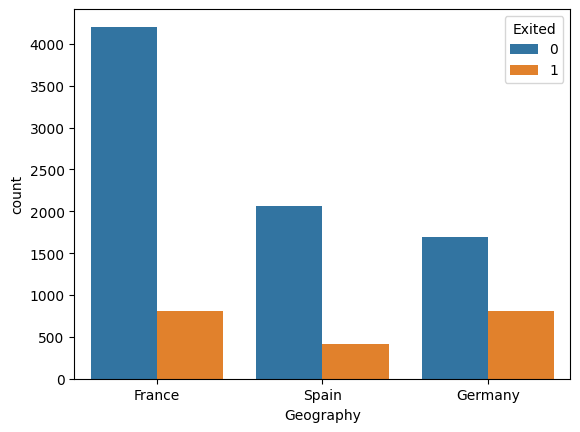

In [38]:
sns.countplot(data=df, x='Geography', hue='Exited');

### DISTRIBUIÇÃO DE CHURN POR ATIVIDADE DO CLIENTE

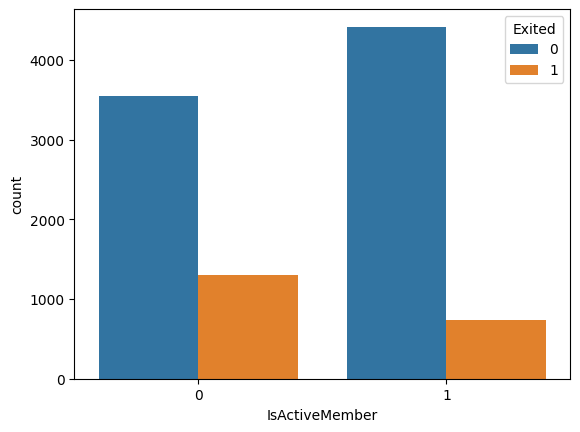

In [39]:
sns.countplot(data=df, x='IsActiveMember', hue='Exited');

### DISTRIBUIÇÃO DE IDADE POR GÊNERO E CHURN

In [40]:
df_aux = df[['Age', 'Gender', 'Exited']].groupby(['Gender', 'Exited']).value_counts().reset_index()
df_aux = df_aux.sort_values(by=['Gender', 'Exited', 'Age'])

#### MULHERES

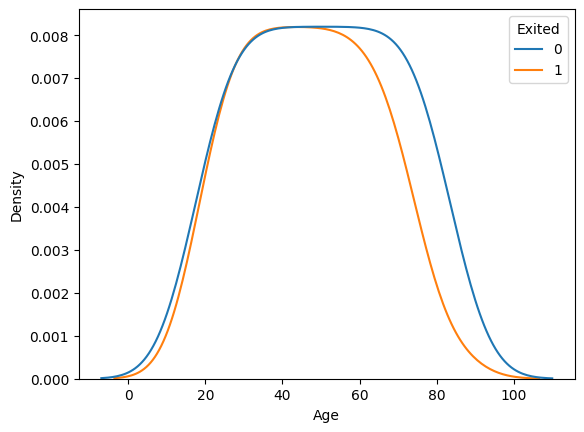

In [41]:
df_aux_f = df_aux.loc[df_aux['Gender'] == 'Female', :]
sns.kdeplot(data=df_aux_f, x='Age', hue='Exited');

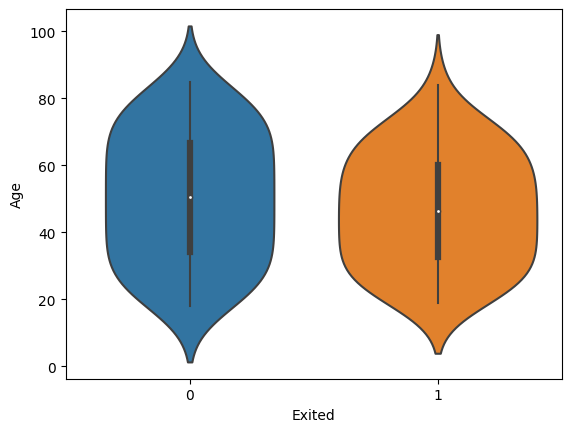

In [42]:
sns.violinplot(x=df_aux_f['Exited'], y=df_aux_f['Age']);

#### HOMENS

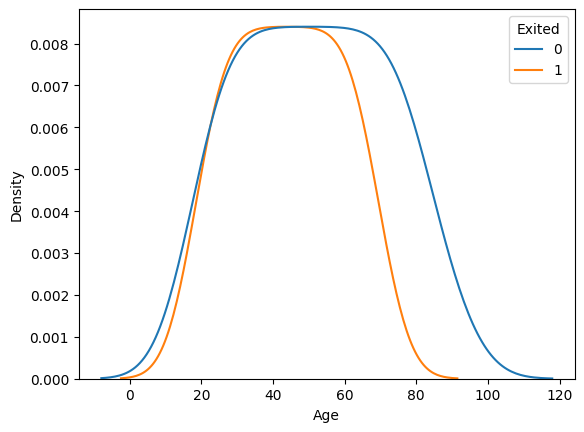

In [43]:
df_aux_m = df_aux.loc[df_aux['Gender'] == 'Male', :]
sns.kdeplot(data=df_aux_m, x='Age', hue='Exited');

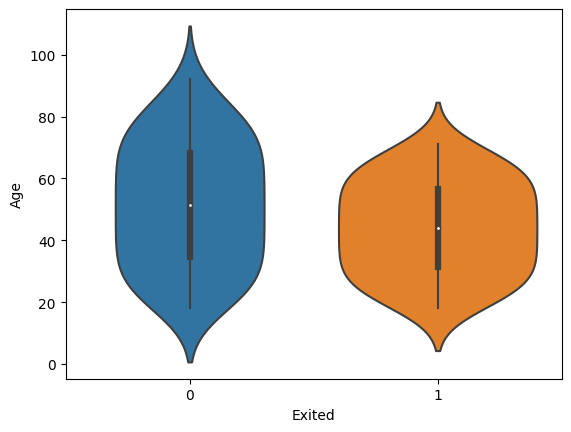

In [44]:
sns.violinplot(x=df_aux_m['Exited'], y=df_aux_m['Age']);

### DISITRIBUIÇÃO DE CHURN POR SALDO E QUANTIDADE DE PRODUTOS

In [45]:
df_aux = df[['Balance', 'NumOfProducts', 'Exited']].groupby('Balance').value_counts().reset_index()
df_aux.sort_values(by=['Balance','NumOfProducts', 'Exited'])

,Balance,NumOfProducts,Exited,count
1,0.00,1,0,567
2,0.00,1,1,338
0,0.00,2,0,2514
3,0.00,2,1,86
5,0.00,3,0,36
...,...,...,...,...
6385,216109.88,1,1,1
6386,221532.80,1,0,1
6387,222267.63,1,1,1
6388,238387.56,1,1,1


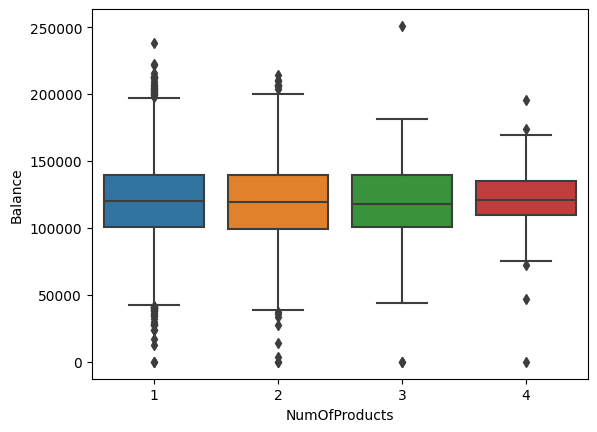

In [46]:
sns.boxplot(x=df_aux['NumOfProducts'], y=df_aux['Balance']);

#### CLIENTES QUE ADQUIRIRAM APENAS 1 PRODUTO

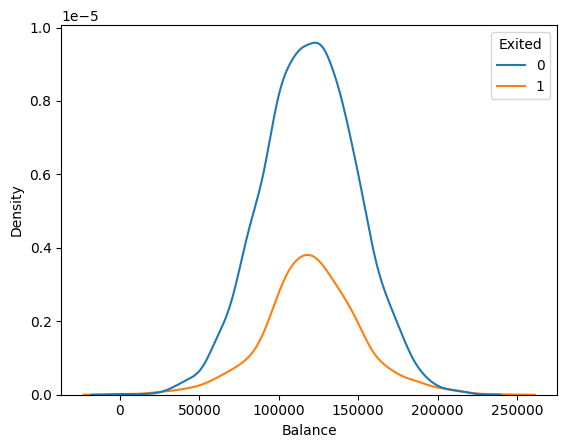

In [47]:
df_aux_1 = df_aux.loc[df_aux['NumOfProducts'] == 1, :]
sns.kdeplot(data=df_aux_1, x='Balance', hue='Exited');

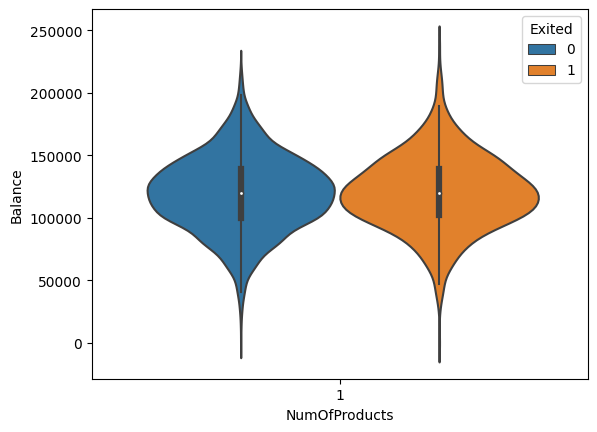

In [48]:
sns.violinplot(x=df_aux_1['NumOfProducts'], y=df_aux['Balance'], hue=df['Exited']);

#### CLIENTES QUE ADQUIRIRAM APENAS 2 PRODUTOS

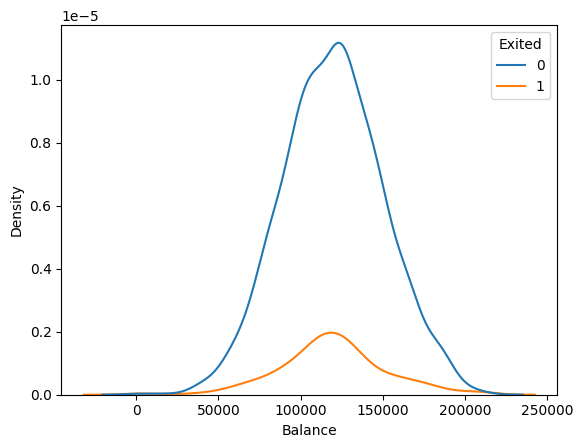

In [49]:
df_aux_2 = df_aux.loc[df_aux['NumOfProducts'] == 2, :]
sns.kdeplot(data=df_aux_2, x='Balance', hue='Exited');

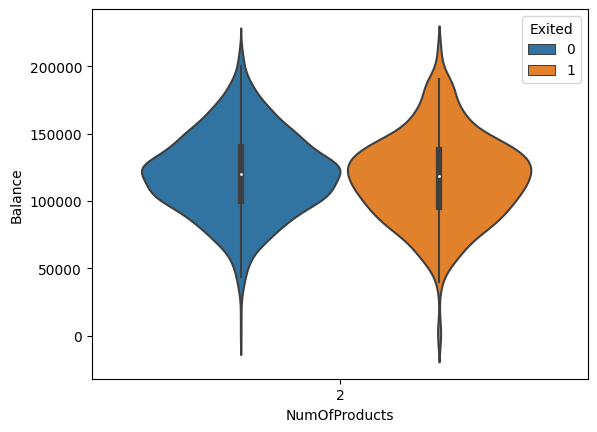

In [50]:
sns.violinplot(x=df_aux_2['NumOfProducts'], y=df_aux['Balance'], hue=df['Exited']);

#### CLIENTES QUE ADQUIRIRAM APENAS 3 PRODUTOS

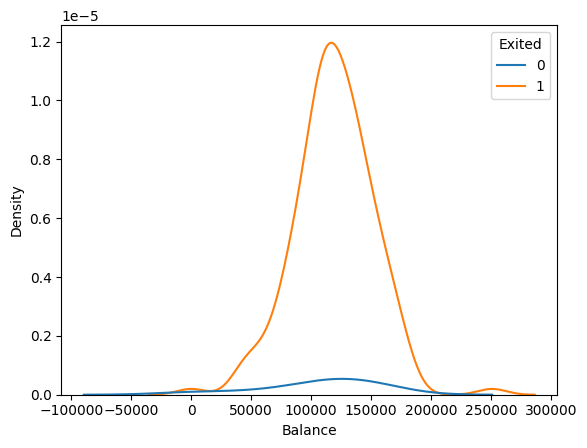

In [51]:
df_aux_3 = df_aux.loc[df_aux['NumOfProducts'] == 3, :]
sns.kdeplot(data=df_aux_3, x='Balance', hue='Exited');

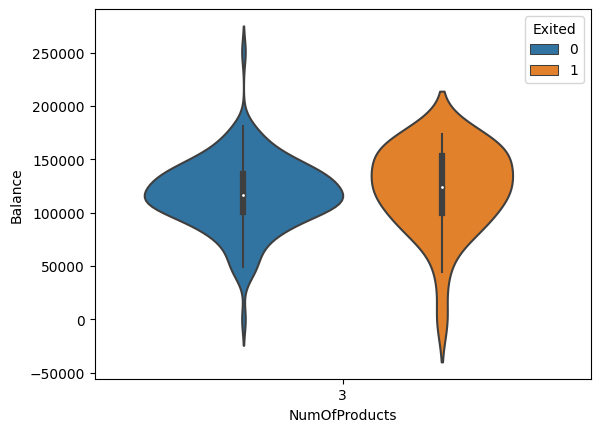

In [52]:
sns.violinplot(x=df_aux_3['NumOfProducts'], y=df_aux['Balance'], hue=df['Exited']);

#### CLIENTES QUE ADQUIRIRAM 4 PRODUTOS

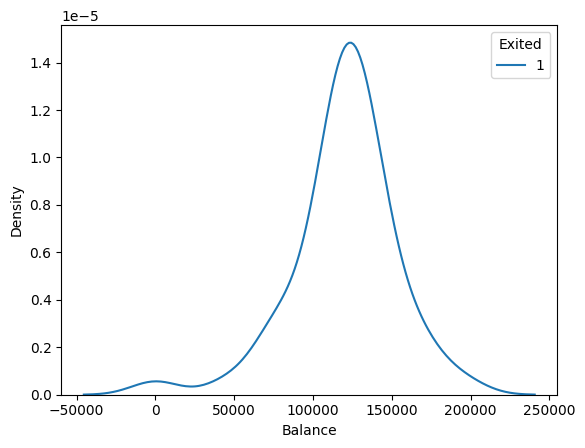

In [53]:
df_aux_4 = df_aux.loc[df_aux['NumOfProducts'] == 4, :]
sns.kdeplot(data=df_aux_4, x='Balance', hue='Exited');

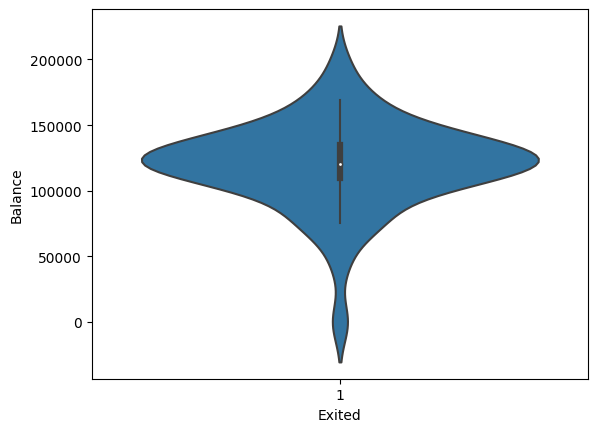

In [54]:
sns.violinplot(x=df_aux_4['Exited'], y=df_aux['Balance']);

Após a análise podemos verificar o seguinte: 
- Há um grande desbalanceamento na distribuição da variável alvo
- 100% dos clientes que adquiriram 4 produtos entraram em Churn
- Em sua maior parte as distribuições das variáveis Gender, Age, CreditScore, Tenure, IsActiveMember, EstimatedSalary,  são similares entre clientes em Churn e Não Churn

Podemos gerar mais features futuramente para verificar se há algum ponto de mudança nas características das features

## CORRELAÇÃO ENTRE VARIÁVEIS

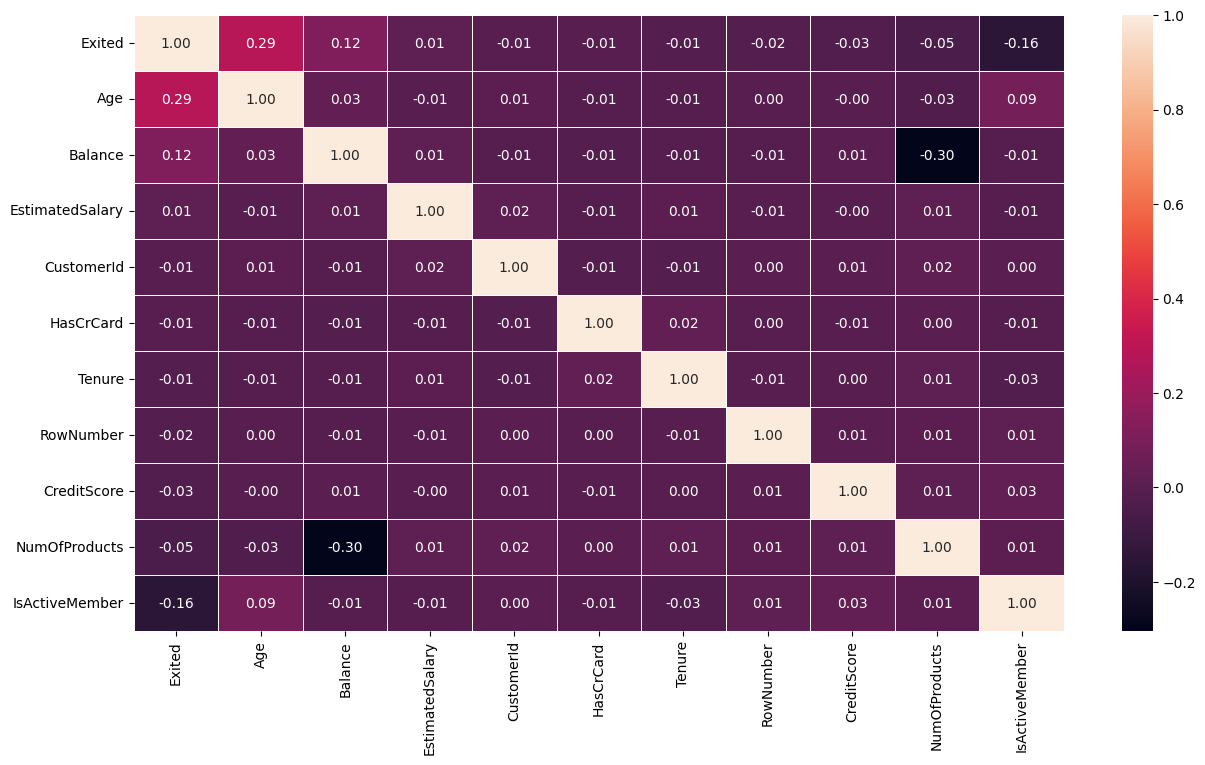

In [55]:
df_numerical = df.select_dtypes(include=('int64', 'float64'))

k = 11
cols = df_numerical.corr().nlargest(k, 'Exited')['Exited'].index

correlation = df_numerical[cols].corr()

plt.figure(figsize=(15,8))
sns.heatmap(correlation, annot=True, fmt=".2f", linewidths=.6);

# MODELAGEM

## PRÉ-PROCESSAMENTO

In [56]:
# remover 3 colunas que não possuem valor para resolver o problema de negócio
df_preprocess = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [57]:
# selecionando as features para modelagem
X = df_preprocess.drop(columns=['Exited'], axis=1)

# separando a variável alvo
y = df_preprocess['Exited']

In [58]:
# separando o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

# salvando os csv de teste e treino
# X_train.to_csv('data/train/X_train.csv', index_label=False, header=True)
# X_test.to_csv('data/test/X_test.csv', index_label=False, header=True)
# y_train.to_csv('data/train/y_train.csv', index_label=False, header=True)
# y_test.to_csv('data/test/y_test.csv', index_label=False, header=True)

## ENCODING E SCALING

### SEPARANDO AS FEATURES NUMÉRICAS E CATEGÓRICAS

In [59]:
# selecionando as features numéricas
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

# selecionando as features categóricas
cat_cols = X.select_dtypes(exclude=['int64', 'float64']).columns

In [60]:
cat_cols_aux = ['Geography', 'Gender']

In [61]:
num_cols

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')

### ENCODING PARA AS FEATURES CATEGÓRICAS

In [62]:
# codificando as features categóricas
te_encoder = TargetEncoder()

# aplicando as variáveis categóricas de treino
X_train_cat = te_encoder.fit_transform(X_train[cat_cols], y_train)

# aplicando as variáveis categóricas de teste
X_test_cat = te_encoder.transform(X_test[cat_cols])
pickle.dump(te_encoder, open('src/encoders/te_encoder.pkl', 'wb'))

In [63]:
# adicionando as features categóricas codificadas no dataset de treino e test
X_train = pd.concat((X_train[num_cols], X_train_cat), axis=1)

X_test = pd.concat((X_test[num_cols], X_test_cat), axis=1)

### ESCALA PARA FEATURES

In [64]:
# escala para features numéricas
rb_scaler = RobustScaler()

# aplicando no dataset de treino
X_train = rb_scaler.fit_transform(X_train)

# aplicando no dataset de teste
X_test = rb_scaler.transform(X_test)
pickle.dump(rb_scaler, open('src/scalers/rb_scaler.pkl', 'wb'))

## SELECIONANDO O MODELO

### RANDOM FOREST CLASSIFIER

In [230]:
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=42, class_weight= {0:1, 1:3.91})

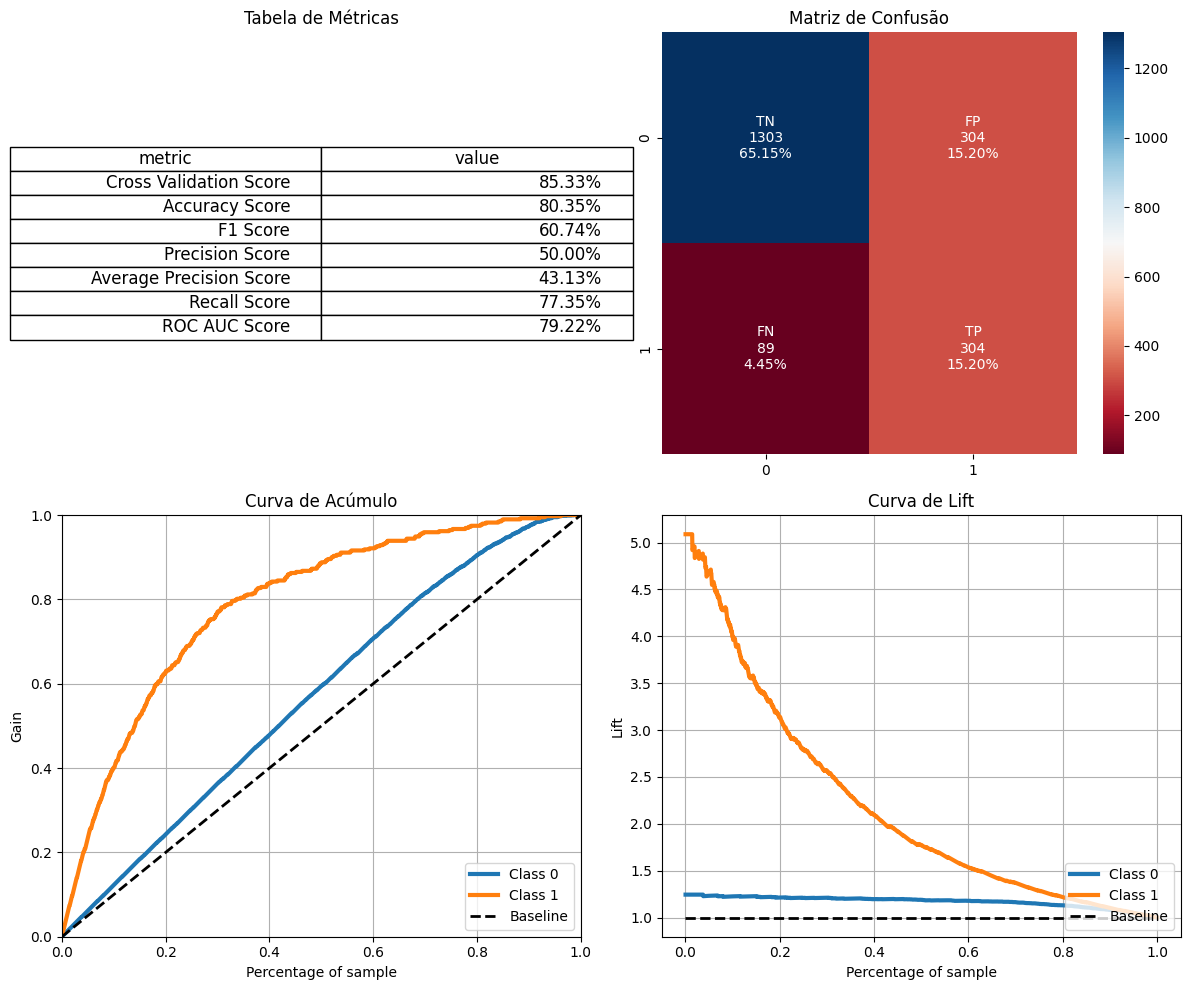

In [231]:
ml_model_and_metrics(rf_model, X_train, y_train, X_test, y_test)

### GRADIENT BOOSTING CLASSIFIER

In [232]:
gbc_model = GradientBoostingClassifier(n_estimators=1000, max_depth=5, random_state=42)

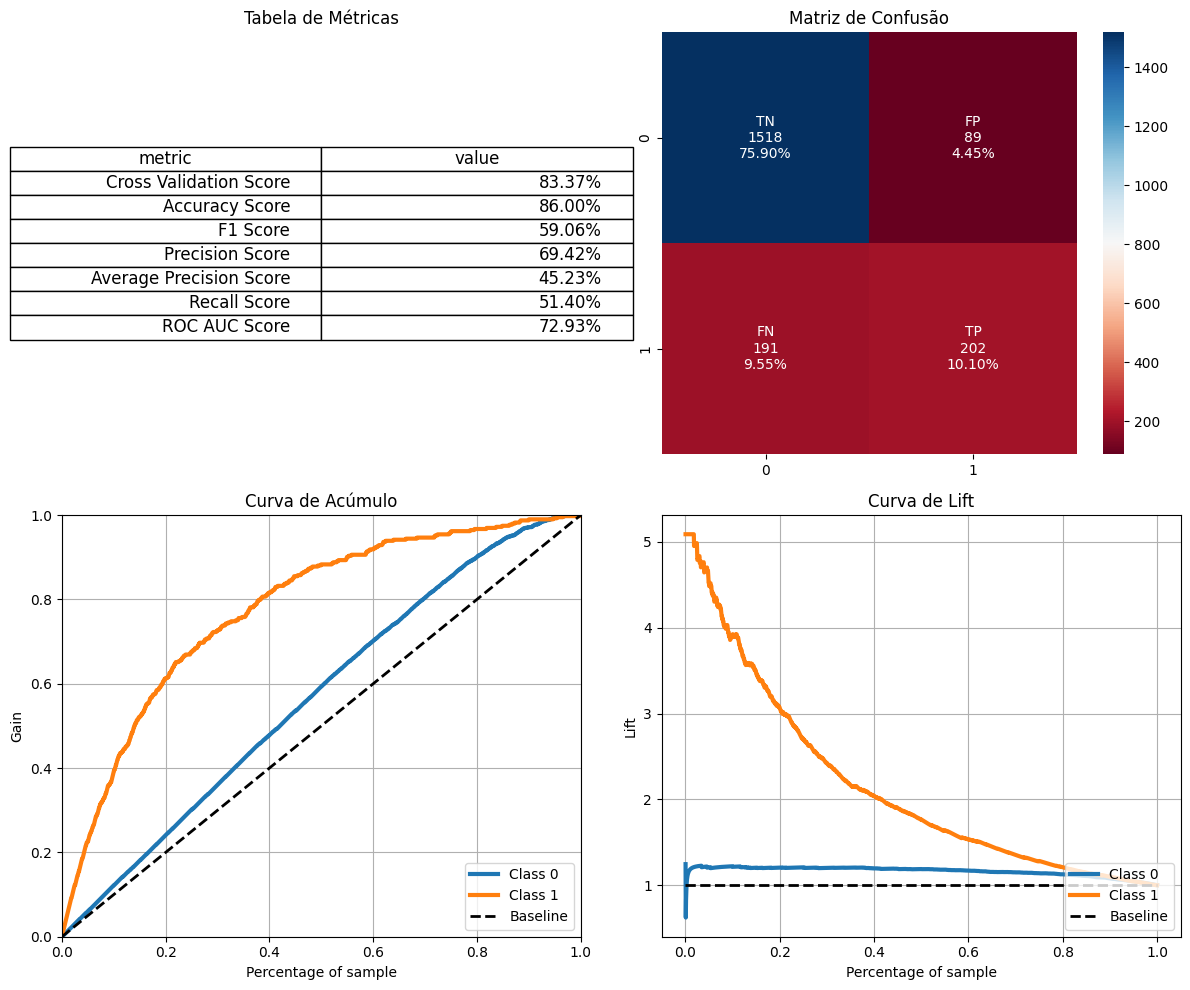

In [233]:
ml_model_and_metrics(gbc_model, X_train, y_train, X_test, y_test)

### XGBOOST CLASSIFIER

In [399]:
xgb_model = XGBClassifier(n_estimators=1000, max_depth=5, random_state=42, scale_pos_weight=3.91)

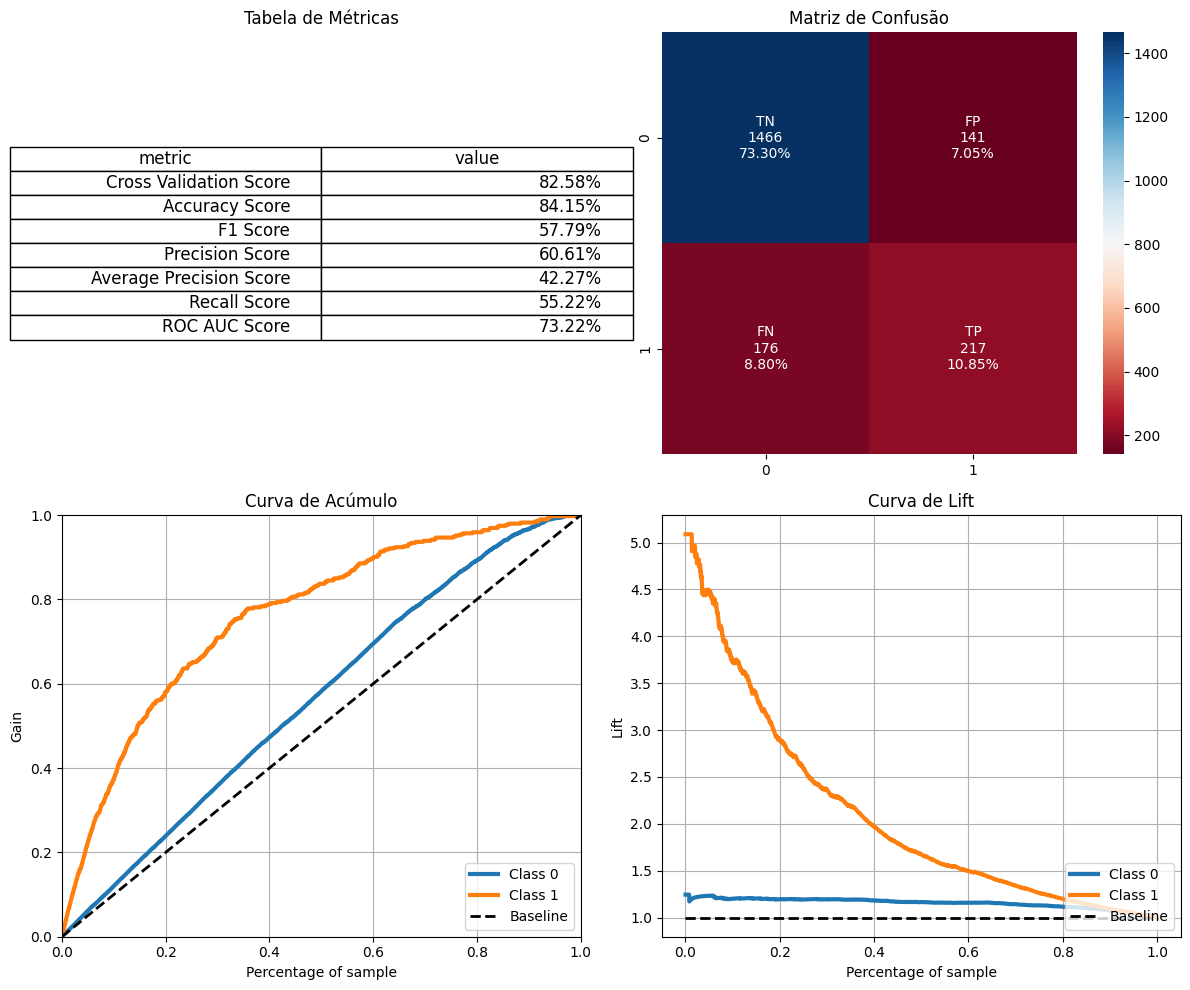

In [403]:
ml_model_and_metrics(xgb_model, X_train, y_train, X_test, y_test)

### LIGHTGBM CLASSIFIER

In [406]:
lgbm_model = LGBMClassifier(n_estimators=1000, max_depth=5, random_state=42, class_weight={0:1, 1:3.91})

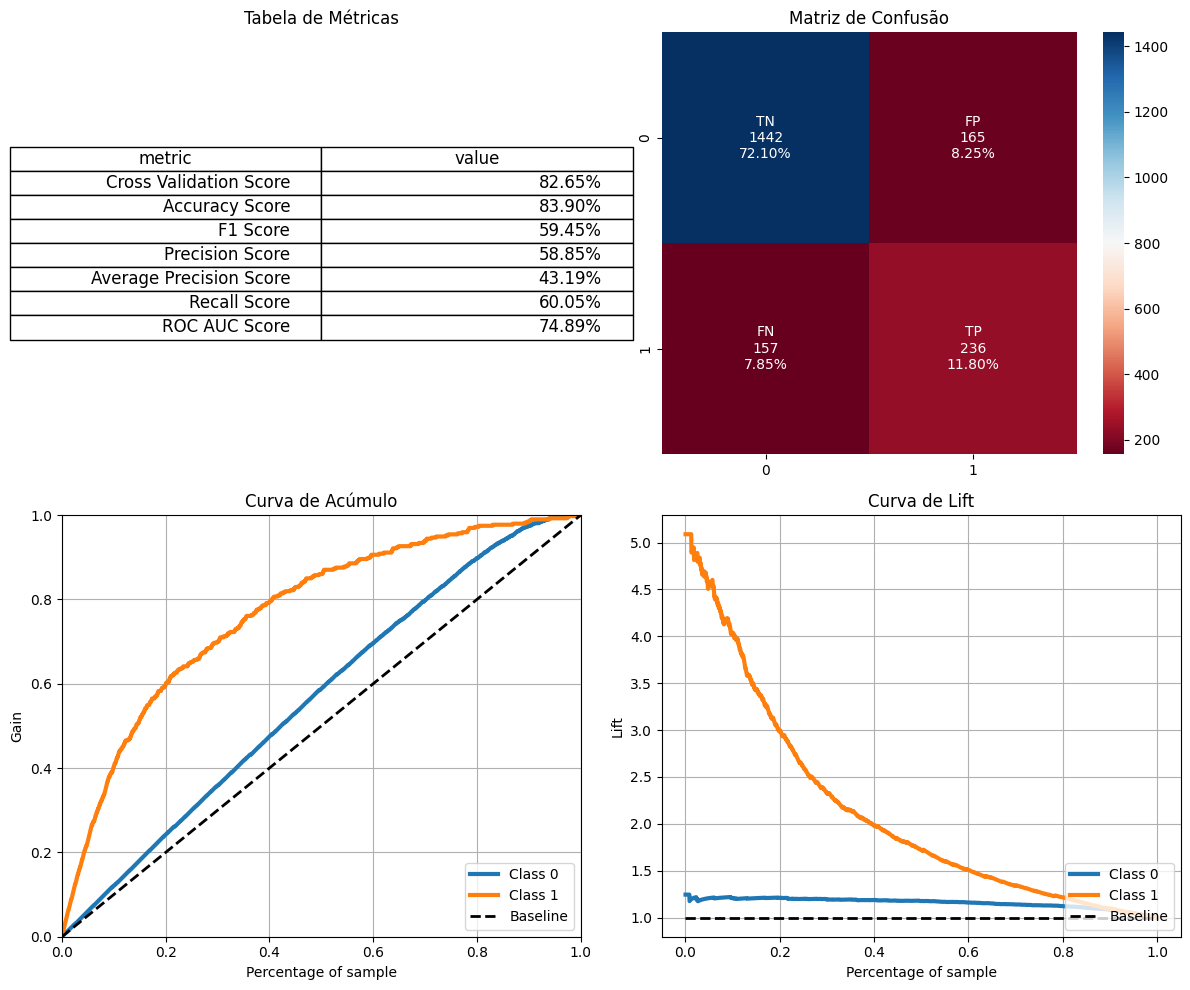

In [407]:
ml_model_and_metrics(lgbm_model, X_train, y_train, X_test, y_test)

### CATBOOST CLASSIFIER

In [409]:
cb_model = CatBoostClassifier(n_estimators=1000, max_depth=5, random_state=42, class_weights={0:1, 1:3.91}, verbose=False)

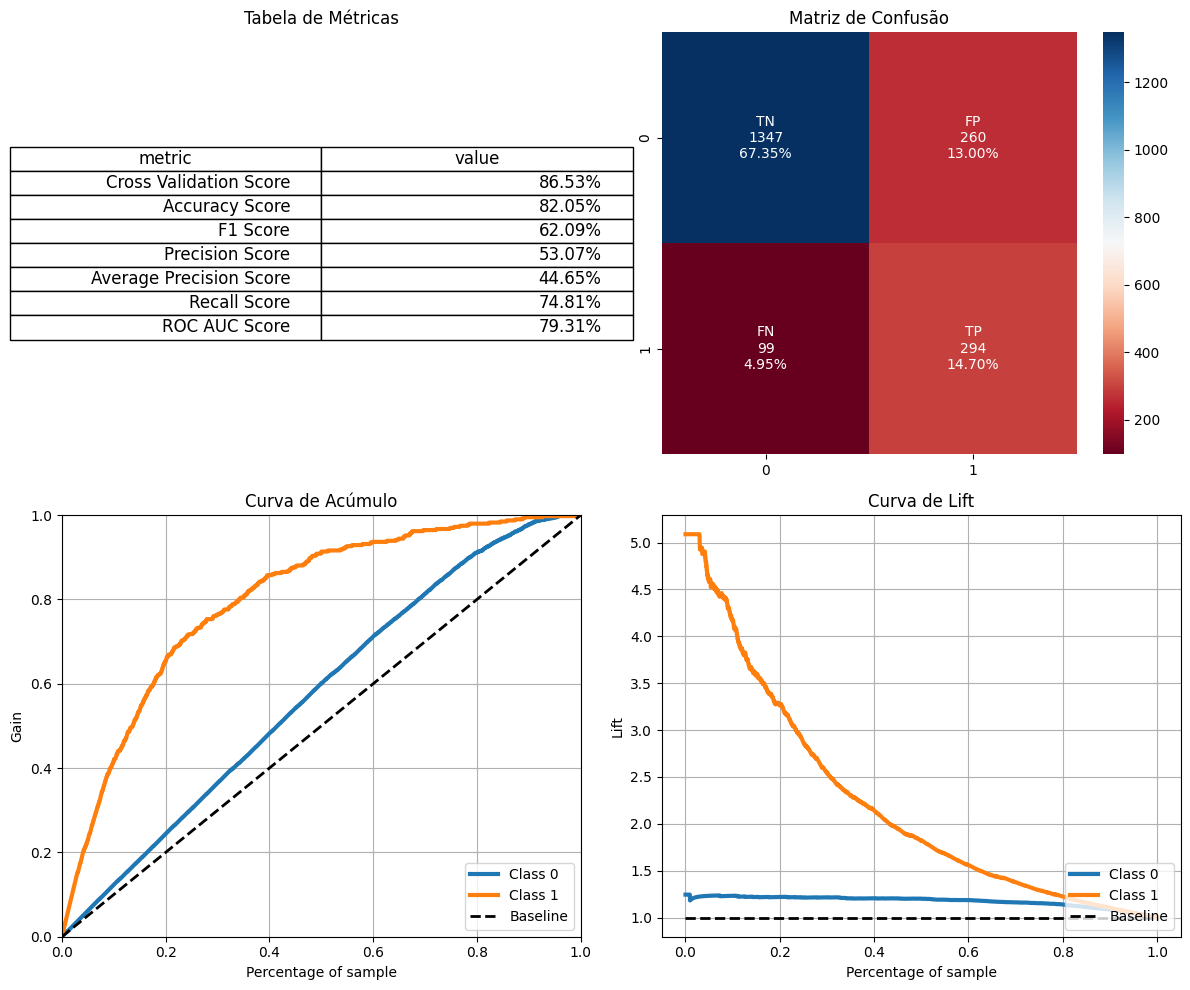

In [410]:
ml_model_and_metrics(cb_model, X_train, y_train, X_test, y_test)

Dentre os modelos de machine learning que escolhemos para testar decidimos seguir com o modelo de Catboost Classifier para realizar o ajuste dos hiperparâmetros e otimizar o modelo.

## HYPERPARAMETERS FINE TUNING

In [98]:
def hyperparameter_fine_tuning(trial):
    cb_model = CatBoostClassifier(
                                iterations=trial.suggest_int('iterations', 100, 1000),
                                learning_rate=trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
                                depth=trial.suggest_int('depth', 2, 10),
                                bootstrap_type=trial.suggest_categorical('bootstrap_type', ['Bayesian']),
                                random_strength=trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
                                bagging_temperature=trial.suggest_float('bagging_temperature', 0.0, 10.0),
                                verbose=False,
                                random_state=42,
                                class_weights= {0:1, 1:3.91})
    
    cb_model.fit(X_train, y_train)
    
    st_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    score = cross_val_score(cb_model, X_train, y_train, cv=st_fold, scoring='roc_auc', n_jobs=-1)
    
    y_pred = cb_model.predict(X_test)
    
    roc_auc = roc_auc_score(y_test, y_pred)
      
    return roc_auc

study = optuna.create_study(direction='maximize')
study.optimize(hyperparameter_fine_tuning, n_trials=100, show_progress_bar=True, n_jobs=-1)

[I 2023-05-31 18:42:47,908] A new study created in memory with name: no-name-7d942545-438b-4b47-a1f7-f6f10082475d
/home/gabriel/.pyenv/versions/churncds/lib/python3.11/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-05-31 18:42:58,873] Trial 1 finished with value: 0.7425235650010846 and parameters: {'iterations': 136, 'learning_rate': 0.021167582330234268, 'depth': 3, 'bootstrap_type': 'Bayesian', 'random_strength': 9.172246456646417e-08, 'bagging_temperature': 7.786617409243764}. Best is trial 1 with value: 0.7425235650010846.
[I 2023-05-31 18:42:58,915] Trial 14 finished with value: 0.7588136191693149 and parameters: {'iterations': 155, 'learning_rate': 0.0014041998257596378, 'depth': 4, 'bootstrap_type': 'Bayesian', 'random_strength': 3.997134493559164e-08, 'bagging_temperature': 4.859423302157046}. Best is trial 14 with value: 0.7588136191693149.
[I 2023-05-31 18:43:18,183] Trial 5 finished with value: 0.7509797308530902 and parameters: {'iterations': 355, 'learning_rate': 0.003746134020678835, 'depth': 4, 'bootstrap_type': 'Bayesian', 'random_strength': 1.3060643851951813e-06, 'bagging_temperature': 7.4724906755136224}. Best is trial 14 with value: 0.7588136191693149.
[I 2023-05-31 18

[I 2023-05-31 18:52:23,679] Trial 26 finished with value: 0.7944156528926405 and parameters: {'iterations': 800, 'learning_rate': 0.08658923425816432, 'depth': 3, 'bootstrap_type': 'Bayesian', 'random_strength': 2.6484890318348685e-06, 'bagging_temperature': 6.667264473101866}. Best is trial 3 with value: 0.8045446844356196.
[I 2023-05-31 18:53:13,995] Trial 27 finished with value: 0.7865944318036073 and parameters: {'iterations': 945, 'learning_rate': 0.05581104568403551, 'depth': 6, 'bootstrap_type': 'Bayesian', 'random_strength': 1.761359065676733e-08, 'bagging_temperature': 5.406372047197245}. Best is trial 3 with value: 0.8045446844356196.
[I 2023-05-31 18:53:23,162] Trial 15 finished with value: 0.7289268800144406 and parameters: {'iterations': 703, 'learning_rate': 0.021773002218459233, 'depth': 10, 'bootstrap_type': 'Bayesian', 'random_strength': 5.771050743132588e-06, 'bagging_temperature': 5.451717747852971}. Best is trial 3 with value: 0.8045446844356196.
[I 2023-05-31 18:53

[I 2023-05-31 19:01:25,524] Trial 50 finished with value: 0.7905220639346625 and parameters: {'iterations': 482, 'learning_rate': 0.02901568524719456, 'depth': 7, 'bootstrap_type': 'Bayesian', 'random_strength': 0.014519165686767851, 'bagging_temperature': 0.1914895549556741}. Best is trial 36 with value: 0.8052778002093259.
[I 2023-05-31 19:01:39,917] Trial 51 finished with value: 0.7966276674409509 and parameters: {'iterations': 488, 'learning_rate': 0.028705441942503507, 'depth': 7, 'bootstrap_type': 'Bayesian', 'random_strength': 0.02785854226808938, 'bagging_temperature': 2.3074426204332164}. Best is trial 36 with value: 0.8052778002093259.
[I 2023-05-31 19:02:02,070] Trial 52 finished with value: 0.7984390809293311 and parameters: {'iterations': 506, 'learning_rate': 0.030124225498715563, 'depth': 7, 'bootstrap_type': 'Bayesian', 'random_strength': 0.04998195575398313, 'bagging_temperature': 1.982876591283432}. Best is trial 36 with value: 0.8052778002093259.
[I 2023-05-31 19:02:

[I 2023-05-31 19:07:42,721] Trial 75 finished with value: 0.8043720934651358 and parameters: {'iterations': 306, 'learning_rate': 0.01549178559120361, 'depth': 8, 'bootstrap_type': 'Bayesian', 'random_strength': 0.28970392002682616, 'bagging_temperature': 0.9426718921324113}. Best is trial 72 with value: 0.8059554968640696.
[I 2023-05-31 19:08:00,671] Trial 76 finished with value: 0.8031275383935739 and parameters: {'iterations': 330, 'learning_rate': 0.010690902944550844, 'depth': 8, 'bootstrap_type': 'Bayesian', 'random_strength': 0.27978516557688893, 'bagging_temperature': 1.068441710103204}. Best is trial 72 with value: 0.8059554968640696.
[I 2023-05-31 19:08:12,270] Trial 77 finished with value: 0.7955216601667957 and parameters: {'iterations': 302, 'learning_rate': 0.0147362352289749, 'depth': 8, 'bootstrap_type': 'Bayesian', 'random_strength': 0.2721764971086851, 'bagging_temperature': 1.2031666275385615}. Best is trial 72 with value: 0.8059554968640696.
[I 2023-05-31 19:08:30,4

In [100]:
print('Número de teste: ', len(study.trials))
print('Melhor teste:')
trial = study.best_trial
print('  Score: ', trial.value)
print('  Parâmetros:'  )
for key, value in trial.params.items():
    print(f'    {key}: {value}')

Número de teste:  100
Melhor teste:
  Score:  0.8081611777987843
  Parâmetros:
    iterations: 409
    learning_rate: 0.009701988181198946
    depth: 8
    bootstrap_type: Bayesian
    random_strength: 0.0051411111893537274
    bagging_temperature: 0.8761487871274863


In [65]:
cb_model_tuned = CatBoostClassifier(iterations=778, 
                                    learning_rate=0.027632349620535467, 
                                    depth=3, 
                                    bootstrap_type = 'Bayesian', 
                                    random_strength = 1.3871396640071362e-08,
                                    bagging_temperature = 1.6958063192219157,
                                    random_state=42,
                                    verbose = False,
                                    class_weights= {0:1, 1:3.91})

In [66]:
# salvando o modelo treinado
cb_model_tuned.fit(X_train, y_train)
pickle.dump(cb_model_tuned, open('/home/gabriel/repos/churn_prediction/src/models/cb_model_tuned.pkl', 'wb'))

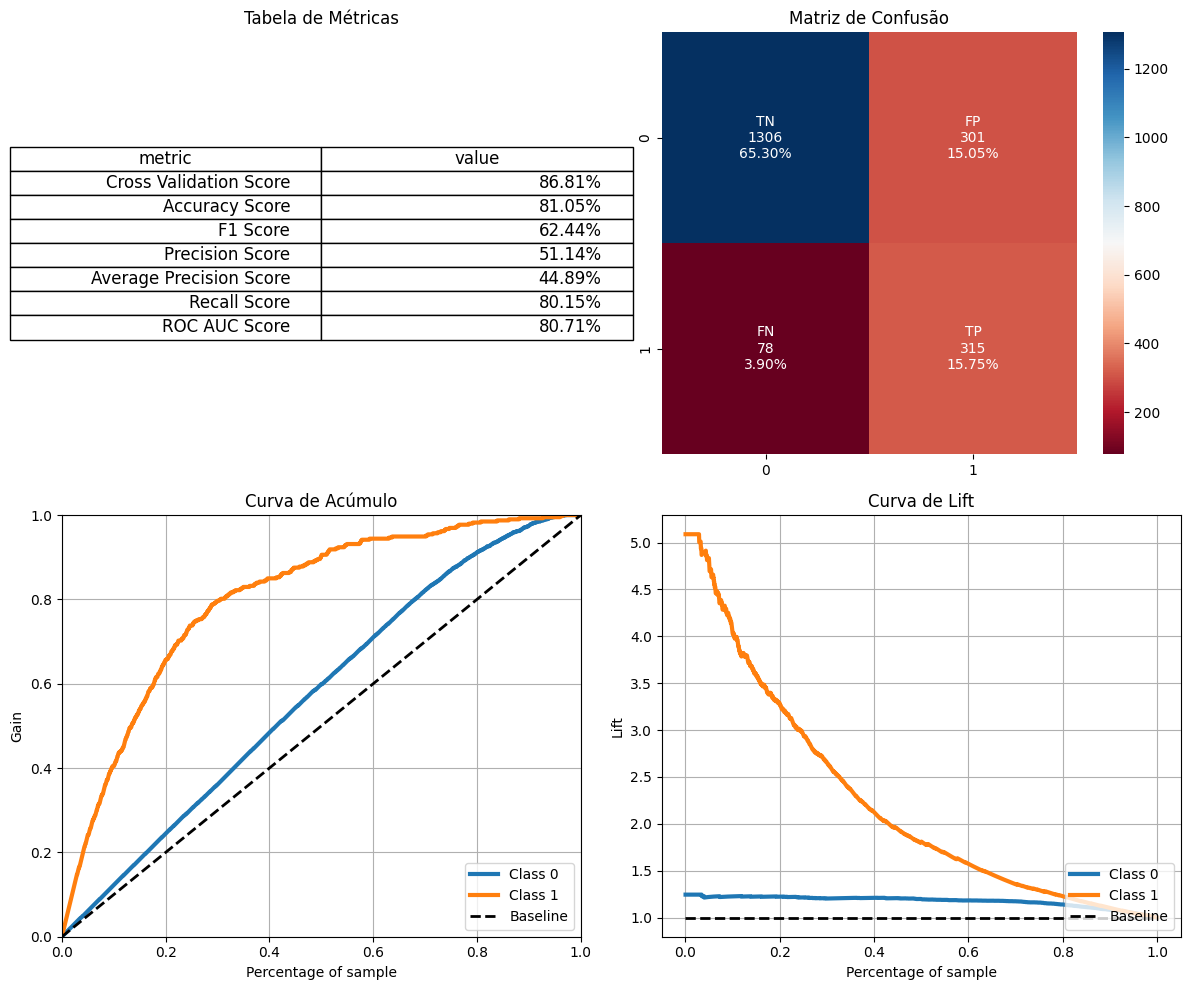

In [67]:
ml_model_and_metrics(cb_model_tuned, X_train, y_train, X_test, y_test)

# ANÁLISE DOS RESULTADOS

In [68]:
y_pred, score = ml_model(cb_model_tuned, X_train, y_train, X_test)

In [69]:
# criando cópias do dataframes
y_test_aux = y_test.copy()
X_test_aux = pd.read_csv('data/test/X_test.csv').copy()
y_pred_aux = pd.Series(y_pred.copy())

# criando um dataframe auxiliar
y_test_aux = y_test_aux.reset_index().drop(columns='index', axis=1)

# selecionando os valores em comum do previsto e do teste
mask = y_pred_aux[(y_test_aux['Exited'] == y_pred_aux)]

# # selecionando os valores de churn que é 1
churn = mask[mask == 1].index

# criando o dataset de resultado
results = X_test_aux.reset_index().drop('index', axis=1).loc[churn, :]
results

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
7,597,Germany,Female,22,6,101528.61,1,1,0,70529.00
10,481,France,Female,57,9,0.00,3,1,1,169719.35
11,651,France,Female,56,4,0.00,1,0,0,84383.22
12,850,France,Male,47,6,0.00,1,1,0,187391.02
25,678,France,Female,49,3,204510.94,1,0,1,738.88
...,...,...,...,...,...,...,...,...,...,...
1983,745,France,Female,55,9,110123.59,1,0,1,51548.14
1993,683,Germany,Female,43,4,115888.04,1,1,1,117349.19
1995,602,Germany,Female,53,5,98268.84,1,0,1,45038.29
1997,730,France,Female,47,7,0.00,1,1,0,33373.26


Segundo o time de Analytics da TopBank, cada cliente que possui essa conta bancária retorna um valor monetário de 15% do valor do seu salário estimado se esse for menor que a média salarial e 20% quando o valor está acima da média salarial durante o período de vigência da conta. Este valor é calculado **anualmente**.

In [98]:
results['Revenue'] = results.apply(lambda x: x['EstimatedSalary'] * 0.2 if x['EstimatedSalary'] > results['EstimatedSalary'].mean() 
                                                                        else x['EstimatedSalary'] * 0.15, axis=1)

results.sort_values(by='Revenue', ascending=False)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Revenue,Category
111,555,Germany,Female,51,9,138214.50,1,1,0,198715.27,39743.0540,1
1520,447,France,Male,41,3,0.00,4,1,1,197490.39,39498.0780,1
1429,623,France,Male,45,0,0.00,1,1,0,196533.72,39306.7440,1
730,610,Germany,Male,50,1,113957.01,2,1,0,196526.55,39305.3100,1
761,591,France,Female,56,9,128882.49,1,1,1,196241.94,39248.3880,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1612,665,Germany,Female,51,9,110610.41,2,0,1,1112.76,166.9140,3
25,678,France,Female,49,3,204510.94,1,0,1,738.88,110.8320,3
1501,731,Germany,Female,43,9,79120.27,1,0,0,548.52,82.2780,3
1297,708,France,Male,52,10,105355.81,1,1,0,123.07,18.4605,3


Lembrando que a soma dos incentivos (bônus) para os clientes não pode ultrapassar o total de RS10.000,00 do orçamento. Vamos dividir os clientes em 3 categorias baseado em seu revenue:

In [176]:
def assign_category(revenue):
    if revenue >= 35000:
        return 0
    elif 25000 <= revenue < 35000:
        return 1
    elif 25000 > revenue:
        return 2 

results['Category'] = results['Revenue'].map(assign_category)

Determinadas as categorias iremos desenvolver um algoritmo para para selecionar quais clientes receberão o incentivo financeiro baseado em sua categoria:
- Categoria 0: S200 de incentivo, 
- Categoria 1: S100 de incentivo
- Categoria 2: S50 de incentivo

Afim de maximizar o rendimento, o método escolhido para fazer esta seleção será o de `knapsack dynammic programming`.

In [177]:
results

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Revenue,Category
7,597,Germany,Female,22,6,101528.61,1,1,0,70529.00,10579.3500,2
10,481,France,Female,57,9,0.00,3,1,1,169719.35,33943.8700,1
11,651,France,Female,56,4,0.00,1,0,0,84383.22,12657.4830,2
12,850,France,Male,47,6,0.00,1,1,0,187391.02,37478.2040,0
25,678,France,Female,49,3,204510.94,1,0,1,738.88,110.8320,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1983,745,France,Female,55,9,110123.59,1,0,1,51548.14,7732.2210,2
1993,683,Germany,Female,43,4,115888.04,1,1,1,117349.19,23469.8380,2
1995,602,Germany,Female,53,5,98268.84,1,0,1,45038.29,6755.7435,2
1997,730,France,Female,47,7,0.00,1,1,0,33373.26,5005.9890,2


## SELECIONANDO OS CLIENTES PARA RECEBEREM O BONUS

In [72]:
def clients_selection(clients, budget, bonus_values):
    n = len(clients)  # obtém o número total de clientes
    
    # criação da tabela de programação dinâmica em 2D
    dp = [[0] * (budget + 1) for _ in range(n + 1)]  # cria uma tabela (matriz) inicializada com zeros
    
    selected_clients = []  # lista vazia para armazenar os clientes selecionados
    
    # loop para atribuir a variável client e extrair os valores de revenue e index
    for i in range(1, n + 1):
        client = clients[i - 1]  # obtém o cliente atual
        client_revenue = client['revenue']  # obtém o valor da receita do cliente atual
        client_bonus_index = client['bonus_values_index']  # obtém o índice do valor do bônus do cliente atual
        
        # loop para percorrer os possíveis valores de orçamento
        for j in range(1, budget + 1):
            if bonus_values and client_bonus_index < len(bonus_values): # verifica se há valores de bônus disponíveis e se o índice do bônus do cliente atual é válido dentro da lista `bonus_values`
                bonus = bonus_values[client_bonus_index]  # obtém o valor do bônus do cliente atual
                
                if bonus <= j:
                    # compara o máximo entre selecionar o cliente atual e não selecioná-lo
                    dp[i][j] = max(dp[i - 1][j], client_revenue + dp[i - 1][j - bonus])
                else:
                    # valor máximo permanece o mesmo se o bônus exceder o orçamento atual
                    dp[i][j] = dp[i - 1][j]
            else:
                # valor máximo permanece o mesmo se não houver bônus disponível ou o índice do bônus for maior que o comprimento de bonus_values
                dp[i][j] = dp[i - 1][j]
    
    # determinação dos clientes a serem selecionados
    i, j = n, budget
    while i > 0 and j > 0:
        if dp[i][j] != dp[i - 1][j]:
            client = clients[i - 1]  # obtém o cliente atual
            selected_clients.append(client)  # adiciona o cliente à lista de clientes selecionados
            j -= bonus_values[client['bonus_values_index']]  # reduz o orçamento atual pelo valor do bônus do cliente
        i -= 1
    
    # retorna o rendimento máximo e a lista de clientes selecionados
    return dp[n][budget], selected_clients


In [178]:
def clients_selection(clients, budget, bonus_values):
    """
    Esse código implementa um algoritmo de seleção de clientes com restrição de orçamento, onde os bônus podem 
    ser aplicados para aumentar a receita total. A técnica de programação dinâmica é utilizada para calcular a 
    solução ótima.
    
    clients: list
        Lista com valores e detalhes dos clientes
        
    budget: int
        Valor selecionado para orçamento
        
    bonus_values: int
        Valor para incentivo aos clientes
    
    Como utilizar:
    
    # dataset com os clientes
    clients = [
     {'revenue': 500, 'bonus_values_index': 0},
     {'revenue': 800, 'bonus_values_index': 1},
     {'revenue': 1000, 'bonus_values_index': 2},
     {'revenue': 600, 'bonus_values_index': 0},
     {'revenue': 900, 'bonus_values_index': 1
    ]

    budget = 10000
    bonus_values = [200, 100, 50]

    max_revenue, selected_clients = clients_selection(clients, budget, bonus_values)

    print(f'Rendimento Máximo: {max_revenue}')
    print(f'Clientes Selecionados:')
    for client in selected_clients:
        print(client)   
    """
    
    n = len(clients) 
    
    # criando a tabela de programação dinâmica em 2D
    dp = [[0] * (budget + 1) for _ in range(n + 1)]
    
    # criando lista vazia de clientes
    selected_clients = []
    
    # loop para atribuir a variável client e extrair os valores de revenue e index
    for i in range(1, n + 1):
        client = clients[i - 1]
        client_revenue = client['revenue']
        client_bonus_index = client['bonus_values_index']
        
        # loop para percorrer os possíveis valores de orçamento
        for j in range(1, budget + 1):
            if bonus_values and client_bonus_index < len(bonus_values):
                bonus = bonus_values[client_bonus_index]
                if bonus <= j:
                    dp[i][j] = max(dp[i - 1][j], client_revenue + dp[i - 1][j - bonus])
                else:
                    dp[i][j] = dp[i - 1][j]
            else:
                dp[i][j] = dp[i - 1][j]
    
    # determinando os clientes a serem selecionados
    i, j = n, budget
    while i > 0 and j > 0:
        if dp[i][j] != dp[i - 1][j]:
            client = clients[i - 1]
            selected_clients.append(client)
            j -= bonus_values[client['bonus_values_index']]
        i -= 1
    
    # retornando o rendimento máximo e a lista de clientes selecionados
    return dp[n][budget], selected_clients

In [179]:
# criando uma cópia do dataset original
results_aux = results.copy()

# criando uma lista para colocar o dicionário
clients = []

# iterando sobre as linhas do dataframe
for index, row in results_aux.iterrows():
    # extraindo os valores para 'revenue' e 'bonus_values_index' de cada linha
    revenue = row['Revenue']
    bonus_values_index = row['Category']
    
    # cria um dicionário com os valores extraídos e adiciona a lista de clientes
    client_dict = {'index':index, 'revenue': revenue, 'bonus_values_index': bonus_values_index}
    clients.append(client_dict)

In [181]:
# dataset com os clientes
clients = clients

budget = 10000
bonus_values = [200, 100, 50]

max_revenue, selected_clients = clients_selection(clients, budget, bonus_values)

print(f'Rendimento Máximo: {max_revenue}')
print(f'Clientes Selecionados:')
for client in selected_clients:
    print(client)

Rendimento Máximo: 3297195.0080000004
Clientes Selecionados:
{'index': 1999, 'revenue': 21534.86, 'bonus_values_index': 2}
{'index': 1993, 'revenue': 23469.838000000003, 'bonus_values_index': 2}
{'index': 1959, 'revenue': 34499.162000000004, 'bonus_values_index': 1}
{'index': 1946, 'revenue': 14402.025, 'bonus_values_index': 2}
{'index': 1920, 'revenue': 25776.532000000003, 'bonus_values_index': 1}
{'index': 1887, 'revenue': 27911.72, 'bonus_values_index': 1}
{'index': 1885, 'revenue': 21797.45, 'bonus_values_index': 2}
{'index': 1881, 'revenue': 28723.904, 'bonus_values_index': 1}
{'index': 1871, 'revenue': 20262.93, 'bonus_values_index': 2}
{'index': 1864, 'revenue': 21878.638000000003, 'bonus_values_index': 2}
{'index': 1828, 'revenue': 32162.170000000002, 'bonus_values_index': 1}
{'index': 1806, 'revenue': 14044.449, 'bonus_values_index': 2}
{'index': 1790, 'revenue': 24729.314000000002, 'bonus_values_index': 2}
{'index': 1783, 'revenue': 31428.721999999998, 'bonus_values_index': 1

In [182]:
len(selected_clients)

130

# DEPLOY DO MODELO

Nesta seção iremos criar a Classe com as funções desenvolvidas na criação deste projeto, logo após para instanciar o modelo e realizar a seleção de clientes.

## CHURN PREDICTION CLASS

In [77]:
import pickle
import pandas as pd
import numpy  as np

class ChurnPrediction():
    def __init__(self):
        self.home_path = '/home/gabriel/repos/churn_prediction/'
        self.cb_model_tuned = pickle.load(open(self.home_path + 'src/models/cb_model_tuned.pkl', 'rb'))
        self.te_encoder     = pickle.load(open(self.home_path + 'src/encoders/te_encoder.pkl', 'rb'))
        self.rb_scaler      = pickle.load(open(self.home_path + 'src/scalers/rb_scaler.pkl', 'rb'))

#     def data_cleaning(df):
#         return None
    
#     def feature_engineering(df):
#         return None

    def preprocessing(self, df):
        # selecionando as features numéricas
        num_cols = df.select_dtypes(include=['int64', 'float64']).columns

        # selecionando as features categóricas
        cat_cols = df.select_dtypes(exclude=['int64', 'float64']).columns
        
        # ENCODING
        # aplicando nas variáveis categóricas
        df_preprocess_cat = self.te_encoder.transform(df[cat_cols])

        # adicionando as features categóricas codificadas no dataset de treino e test
        df_preprocess = pd.concat((df[num_cols], df_preprocess_cat), axis=1)

        # SCALLING
        # aplicando dataset
        df_scaled = self.rb_scaler.transform(df_preprocess)
        
        return df_scaled

    def get_prediction(self, model, df_scaled):

        prediction = model.predict(df_scaled)
        
        return prediction
    
    def get_results(prediction, df):
        
        prediction = prediction

        df['prediction'] = prediction

        results = df.loc[df['prediction'] == 1, :]

        return results

    def assign_revenue(self, results):
        
        # criando a coluna revenue para o dataset com os resultados
        results['Revenue'] = results.apply(lambda x: x['EstimatedSalary'] * 0.2 if x['EstimatedSalary'] > results['EstimatedSalary'].mean() 
                                                                            else x['EstimatedSalary'] * 0.15, axis=1)       
        
        return results
    
    def get_category(self, results):
        conditions = [
            results['Revenue'] >= 35000,
            (25000 <= results['Revenue']) & (results['Revenue'] < 35000),
            results['Revenue'] < 25000
        ]
        choices = [0, 1, 2]

        results['Category'] = np.select(conditions, choices)

        return results
    
    def clients_selection(self, clients, budget, bonus_values):
        n = len(clients)

        # criando a tabela de programação dinâmica em 2D
        dp = [[0] * (budget + 1) for _ in range(n + 1)]

        # criando lista vazia de clientes
        selected_clients = []

        # loop para atribuir a variável client e extrair os valores de revenue e index
        for i in range(1, n + 1):
            client = clients[i - 1]
            client_revenue = client['revenue']
            client_bonus_index = client['bonus_values_index']

            # 
            for j in range(1, budget + 1):
                if bonus_values and client_bonus_index < len(bonus_values):
                    bonus = bonus_values[client_bonus_index]
                    if bonus <= j:
                        dp[i][j] = max(dp[i - 1][j], client_revenue + dp[i - 1][j - bonus])
                    else:
                        dp[i][j] = dp[i - 1][j]
                else:
                    dp[i][j] = dp[i - 1][j]

        # determinando os clientes a serem selecionados
        i, j = n, budget
        while i > 0 and j > 0:
            if dp[i][j] != dp[i - 1][j]:
                client = clients[i - 1]
                selected_clients.append(client)
                j -= bonus_values[client['bonus_values_index']]
            i -= 1

        # retornando o rendimento máximo e a lista de clientes selecionados
        return dp[n][budget], selected_clients
    
    def client_list(self, results):
        # criando uma cópia do dataset original
        results_aux = results.copy()

        # criando uma lista para colocar o dicionário
        clients = []

        # iterando sobre as linhas do dataframe
        for index, row in results_aux.iterrows():
            # extraindo os valores para 'revenue' e 'bonus_values_index' de cada linha
            revenue = row['Revenue']
            bonus_values_index = row['Category']
            gender = row['Gender']
            age = row['Age']
            tenure = row['Tenure']
            credit_score = row['CreditScore']
            no_product = row['NumOfProducts']
            credit_card = row['HasCrCard']
            active = row['IsActiveMember']

            # cria um dicionário com os valores extraídos dos resultados e adiciona na lista de clientes
            client_dict = ({
                'index': index,
                'revenue': revenue,
                'bonus_values_index': bonus_values_index,
                'gender': gender,
                'age': age,
                'tenure': tenure,
                'credit_score': credit_score,
                'no_product': no_product,
                'credit_card': credit_card,
                'active': active
            })
            clients.append(client_dict)

        return clients
    
    def select_clients(self, clients):
        # Exemplo
        clients = clients

        budget = 10000
        bonus_values = [200, 100, 50]

        max_revenue, selected_clients = clients_selection(clients, budget, bonus_values)

        selected_clients = pd.DataFrame(selected_clients)
        
        return selected_clients.to_json(orient='records')

## API HANDLER

In [78]:
import pickle
import pandas as pd
import numpy  as np

from flask                           import Flask, request, Response
from churnprediction.ChurnPrediction import ChurnPrediction

#carregando o modelo
model = pickle.load(open('/home/gabriel/repos/churn_prediction/src/models/cb_model_tuned', 'rb'))

# iniciar a API
app = Flask(__name__)

@app.route('/churn_prediction/prediction', methods=['POST'])
def churn_prediction():
    test_json = request.get_json()
    
    if test_json:
        if isinstance(test_json, dict):
            df = pd.DataFrame(test_json, index=[0])
        else:
            df = pd.DataFrame(test_json, columns=test_json[0].keys())
    
        # carregando a classe ChurnPrediction
        pipeline = ChurnPrediction()
        
        # preprocessamento 
        df_scaled = pipeline.preprocessing(df)
        
        # prediction
        prediction = pipeline.get_prediction(model, df_scaled)
        
        # results
        results = pipeline.get_results(prediction, df)
        
        # revenue
        results1 = pipeline.assign_revenue(results)
        
        # category
        results2 = pipeline.get_category(results1)
        
        # clients
        clients = pipeline.client_list(results2)
        
        # client selection
        selected_clients = pipeline.select_clients(clients)
        
        return selected_clients
    
    else: 
        return Response('{}', status=200, mimetype='application/json')
    
if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'churnprediction'

## API TESTER

In [184]:
df_test = pd.read_csv('data/test/X_test.csv')

In [185]:
df_test = json.dumps(df_test.to_dict(orient='records'))

In [186]:
# API Call
#url = 'http://0.0.0.0:5000/churn_prediction/predict'
url = 'https://churn-prediction-api.onrender.com/churn_prediction/predict'
header = {'Content-type': 'application/json'}
data = df_test

r = requests.post(url, data=data, headers=header)
print(f'Status Code {r.status_code}')

Status Code 200


In [187]:
r.json()

[{'index': 1963,
  'revenue': 30269.87,
  'bonus_values_index': 2,
  'gender': 'Female',
  'age': 41,
  'tenure': 9,
  'credit_score': 673,
  'no_product': 1,
  'credit_card': 1,
  'active': 0},
 {'index': 1959,
  'revenue': 34499.162,
  'bonus_values_index': 2,
  'gender': 'Male',
  'age': 52,
  'tenure': 8,
  'credit_score': 646,
  'no_product': 1,
  'credit_card': 0,
  'active': 0},
 {'index': 1952,
  'revenue': 25187.844,
  'bonus_values_index': 2,
  'gender': 'Female',
  'age': 45,
  'tenure': 1,
  'credit_score': 589,
  'no_product': 1,
  'credit_card': 0,
  'active': 0},
 {'index': 1939,
  'revenue': 30251.244,
  'bonus_values_index': 2,
  'gender': 'Male',
  'age': 41,
  'tenure': 5,
  'credit_score': 612,
  'no_product': 3,
  'credit_card': 0,
  'active': 0},
 {'index': 1920,
  'revenue': 25776.532,
  'bonus_values_index': 2,
  'gender': 'Male',
  'age': 47,
  'tenure': 1,
  'credit_score': 560,
  'no_product': 1,
  'credit_card': 0,
  'active': 0},
 {'index': 1888,
  'revenue

In [188]:
df_final = pd.DataFrame(r.json(), columns=r.json()[0].keys())
df_final

,index,revenue,bonus_values_index,gender,age,tenure,credit_score,no_product,credit_card,active
0,1963,30269.870,2,Female,41,9,673,1,1,0
1,1959,34499.162,2,Male,52,8,646,1,0,0
2,1952,25187.844,2,Female,45,1,589,1,0,0
3,1939,30251.244,2,Male,41,5,612,3,0,0
4,1920,25776.532,2,Male,47,1,560,1,0,0
...,...,...,...,...,...,...,...,...,...,...
164,36,28619.298,2,Female,37,9,715,1,0,0
165,13,31681.646,2,Female,41,2,687,1,1,0
166,10,33943.870,2,Female,57,9,481,3,1,1
167,9,32820.948,2,Female,42,3,464,1,1,1


## GOOGLE SCRIPT

In [213]:
function churnprediction() {
  var ui = SpreadsheetApp.getUi()
  ui.createMenu('Churn Prediction - Client List')
    . addItem('Get Prediction', 'PredictAll')
    .addToUi();
};

host_production = 'churn-prediction-api.onrender.com/churn_prediction'

// Helper Function
function ApiCall(data, endpoint){
  var url = 'https://' + host_production + endpoint;
  var payload = JSON.stringify(data);

  var options = {'method': 'POST', 'headers': {'Content-type': 'application/json'}, 'payload': payload};

  var response = UrlFetchApp.fetch(url, options);

  // get response
  var rc = response.getResponseCode();
  var responseText = response.getContentText();

  if (rc !== 200){
    Logger.log('Response (%s) %s', rc, responseText);
  }
  else{
    prediction = JSON.parse(responseText);
  }
  return prediction
  
};

function PredictAll() {
  var ss = SpreadsheetApp.getActiveSpreadsheet();
  var titleColumns = ss.getRange('A1:J1').getValues()[0];
  var lastRow = ss.getLastRow();

  var data = ss.getRange('A2:J' + lastRow).getValues();

  var jsonData = [];

  // Iterar sobre todas as linhas
  for (var row = 0; row < data.length; row++) {
    var json = {};

    // Iterar sobre todas as colunas
    for (var col = 0; col < titleColumns.length; col++) {
      json[titleColumns[col]] = data[row][col];
    }

    jsonData.push(json);
  }

  // Enviar dados JSON para a API
  var response = ApiCall(jsonData, '/predict');

  // Verificar se a resposta é válida
  if (response && response.length > 0) {
    Logger.log(response); // Verificar a resposta no registro

    // Criar uma nova planilha
    var newSheet = ss.insertSheet();

    // Definir o nome da planilha
    newSheet.setName('Prediction Results');

    // Escrever os cabeçalhos das colunas
    var columnOffset = 1;
    for (var key in response[0]) {
      newSheet.getRange(1, columnOffset).setValue(key);
      columnOffset++;
    }

    // Escrever os valores de resposta
    var rowOffset = 2;
    for (var row = 0; row < response.length; row++) {
      var rowData = response[row];
      columnOffset = 1;
      for (var key in rowData) {
        newSheet.getRange(row + rowOffset, columnOffset).setValue(rowData[key]);
        columnOffset++;
      }
    }
  }
}


SyntaxError: invalid syntax (1931750052.py, line 1)